In [1]:
from normalize import *

leiden-1 Cell number: 6450


/home/rzh/Browser/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


6377 Cells retained after scrublet, 73 cells reomved.


2024-04-11 10:29:44,268 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-04-11 10:29:45,370 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-04-11 10:29:45,393 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2024-04-11 10:29:46,282 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2024-04-11 10:29:47,173 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2024-04-11 10:29:48,068 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations
2024-04-11 10:29:48.630568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 10:29:48.678154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This Te

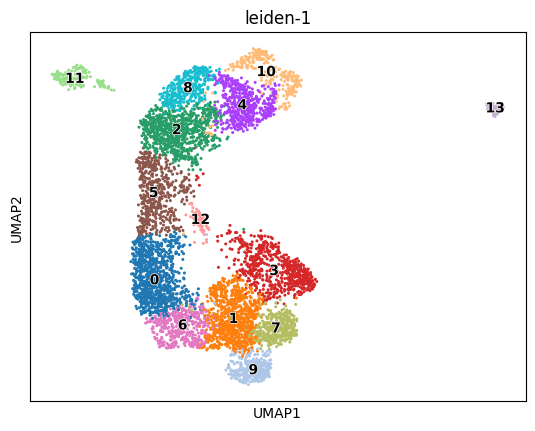

{'Adrenergic neurons': ['13'],
 'Astrocytes': ['11', '2', '8', '4', '5'],
 'Dopaminergic neurons': ['0', '6'],
 'Erythroblasts': ['0', '6'],
 'GABAergic neurons': ['3', '1', '7'],
 'Glycinergic neurons': ['3', '1'],
 'Immature neurons': ['5', '6', '0'],
 'Microglia': ['11'],
 'Motor neurons': ['1', '3'],
 'Neural stem/precursor cells': ['3'],
 'Neuroblasts': ['5'],
 'Neurons': ['9', '1', '7', '3'],
 'Oligodendrocyte progenitor cells': ['7', '1', '3'],
 'Pinealocytes': ['0'],
 'Platelets': ['11'],
 'Purkinje neurons': ['3', '1', '7'],
 'Pyramidal cells': ['6', '0'],
 'Radial glia cells': ['4', '8', '2', '5'],
 'Schwann cells': ['7']}

In [2]:
samples = ["/data/rzh/outs/10X12_3_A_1/outs/filtered_feature_bc_matrix.h5",
           "/data/rzh/outs/10X12_4_A_1/outs/filtered_feature_bc_matrix.h5"]
sampleNames = ['dorsal', 'ventral']
organs=['Brain', 'Blood']
adata = concat_adata(samples, sampleNames, inputFunc=input_adata_10Xh5)
adata = pp(adata)
adata = clu(adata)
adata = rank(adata, organs, alpha=10e-50)
adata.uns['UCell_Assign']

... storing 'annotation' as categorical


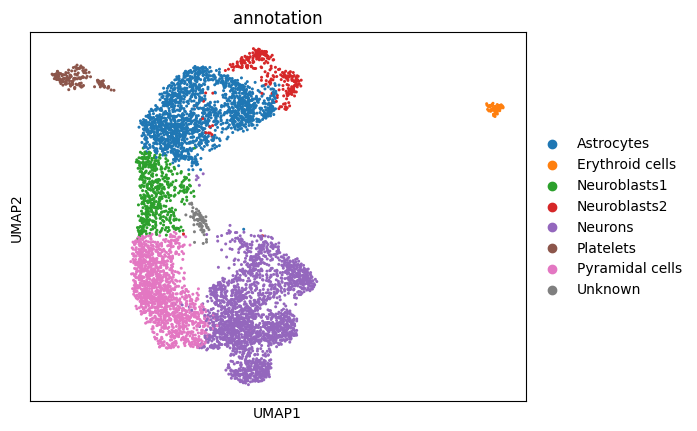

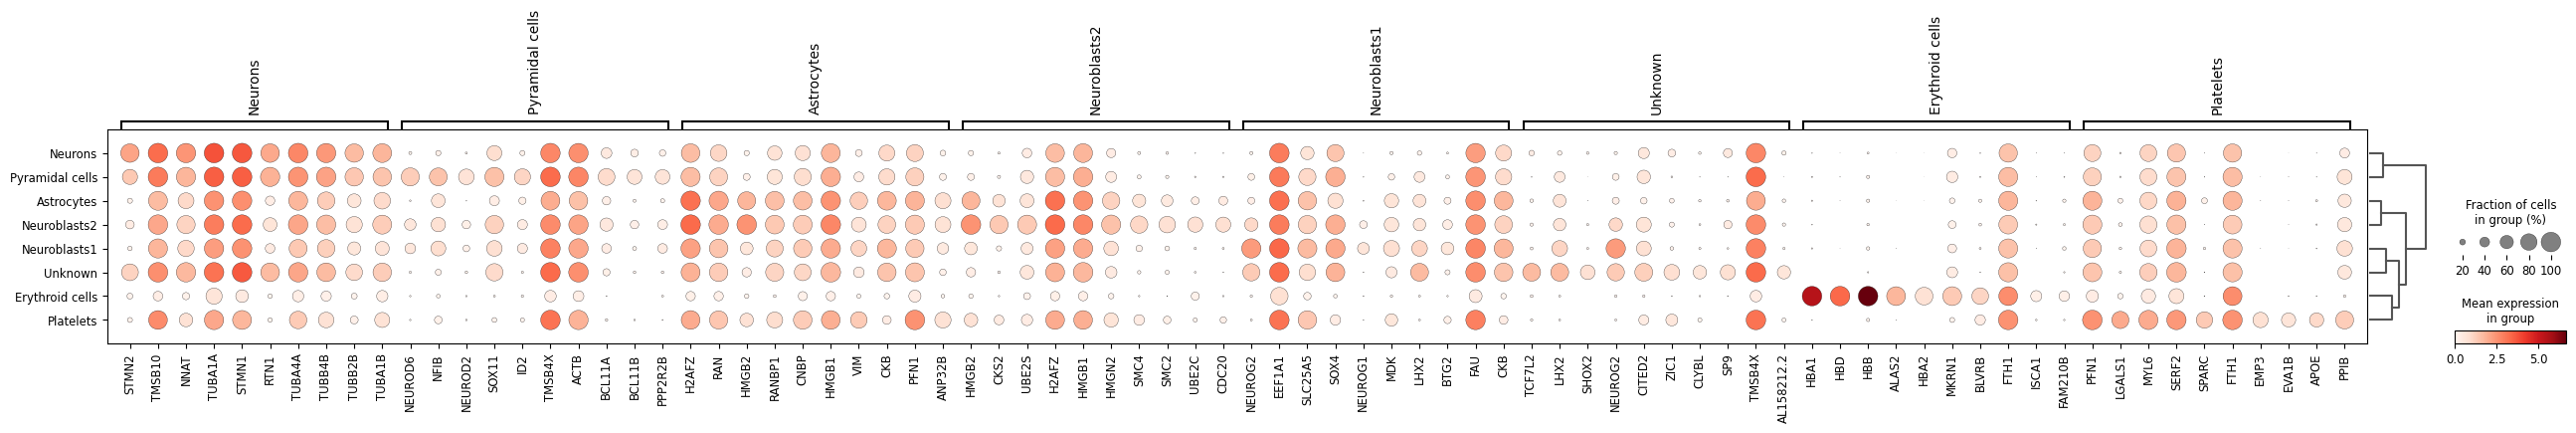

In [3]:
annoDict = {
  'Pyramidal cells': ['6', '0'],
  'Platelets': ['11'],
  'Erythroid cells': ['13'],
  'Interneurons': ['3'],
  'Trigeminal neurons': ['7'],
  'Astrocytes': ['2','8','4'],
  
  'Neurons': ['9', '1', '7', '3'], 
  'Neuroblasts1': ['5'],
  'Neuroblasts2': ['10'],
}
adata = anno(adata, annoDict)
sc.pl.umap(adata, color='annotation')
adata = marker(adata)
adata.write_h5ad("/data/rzh/RawUrls/235/sc/sc1.h5ad")

In [18]:
sampleIdx = np.random.choice(len(adata), 3000)
adata.obs.columns = [s.replace('/', ' or ') for s in adata.obs.columns]
adata.obsm['AUCell_rankings'] = np.array(adata.obsm['AUCell_rankings'], dtype=int)
adata0 = adata[sampleIdx,adata.var['highly_variable']].copy()
adata0.write_h5ad("/data/rzh/RawUrls/235/sc/sc1_sampled.h5ad")

In [19]:
adata.obsm['AUCell_rankings']

array([[9656, 2374, 6723, ..., 9900, 9911, 9882],
       [6723, 4354, 7615, ...,  277, 8710, 8729],
       [6723, 4354,   68, ...,  523,  524,  525],
       ...,
       [9656, 2374, 5382, ..., 4148, 4119, 4039],
       [5382, 9656, 5962, ...,  531,  532,  533],
       [2374, 5382, 6723, ...,  528,  529,  530]])

In [ ]:
#Spatial Transcriptomics data analysis

In [4]:
def input_adata_10X(sample):
    adata = sc.read_mtx(sample+'/matrix.mtx.gz')
    adata = adata.T
    bar = pd.read_csv(sample+'/barcodes.tsv.gz', header=None)
    fea = pd.read_csv(sample+'/features.tsv.gz', header=None, sep='\t')
    bar.columns = ['barcodes']
    fea.columns = ['ID', 'name', 'type']
    adata.obs_names = bar.iloc[:,0]
    adata.obs_names_make_unique()
    adata.var = fea
    adata.var_names = fea.iloc[:,1]
    adata.var_names_make_unique()
    adata
    return adata

def input_adata_10Xh5(sample):
    adata = sc.read_10x_h5(sample)
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    return adata

# 将所有矩阵合并
def concat_adata(samples, sampleNames, inputFunc=input_adata_10Xh5):
    adatas = []
    for i in range(len(sampleNames)):
        adata = inputFunc(samples[i])
        adatas.append(adata)
    if len(adatas) > 0:
        intersection_var = set(adatas[0].var_names)
        for a in adatas[1:]:
            intersection_var &= set(a.var_names)
        common_vars = list(intersection_var)
        for i in range(len(adatas)):
            adatas[i] = adatas[i][:, common_vars]
    # 进行数据合并
    adata_concat = adatas[0].concatenate(adatas[1:], batch_categories=sampleNames)
    adata_concat
    return adata_concat

In [3]:
# 预处理
def pp(adata):
    mito_genes = adata.var_names.str.startswith('MT-')
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['mt_frac'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    
    # 过滤低表达的基因
    sc.pp.filter_cells(adata, min_genes=5)  # 过滤一个细胞中表达少于五个基因的细胞样本 
    sc.pp.filter_genes(adata, min_cells=5)  # 过滤在少于五个细胞中表达的基因
    sc.pp.filter_cells(adata, min_counts=30)   # 过滤每个细胞中计数少于29个的细胞样本 

    # 过滤线粒体核糖体基因
    rp_genes = adata.var_names.str.startswith('RP')
    mt_genes = adata.var_names.str.startswith('MT-')
    adata = adata[:, ~(rp_genes + mt_genes)]
    adata = adata[adata.obs['mt_frac'] < 0.2]
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=2000)
    return adata

# macro_Mye = scv.read('velo-Macro.h5ad')
def clu(adata, key_added="leiden-1", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=True, max_iter=20, resolution=1, do_scrublet=True, har_key='batch'):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.pp.scrublet(adata, random_state=112)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True)
    if do_har:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added=key_added, resolution=resolution)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

def marker(adata, groupby="leiden-1", method='wilcoxon'):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby)
    return adata

leiden-1 Cell number: 6450
6377 Cells retained after scrublet, 73 cells reomved.


2024-04-11 07:40:18,798 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-04-11 07:40:19,958 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-04-11 07:40:19,978 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2024-04-11 07:40:20,902 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2024-04-11 07:40:21,776 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2024-04-11 07:40:22,627 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations
... storing 'feature_types' as categorical
... storing 'genome' as categorical


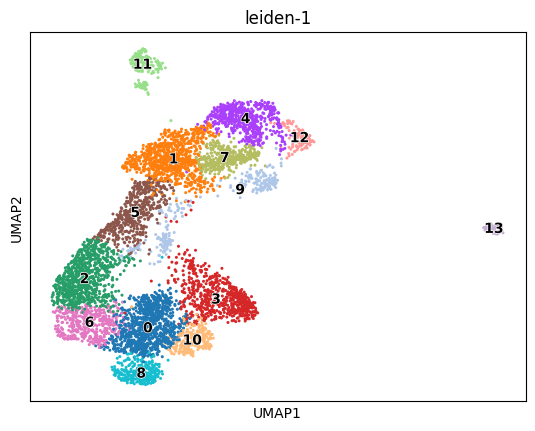

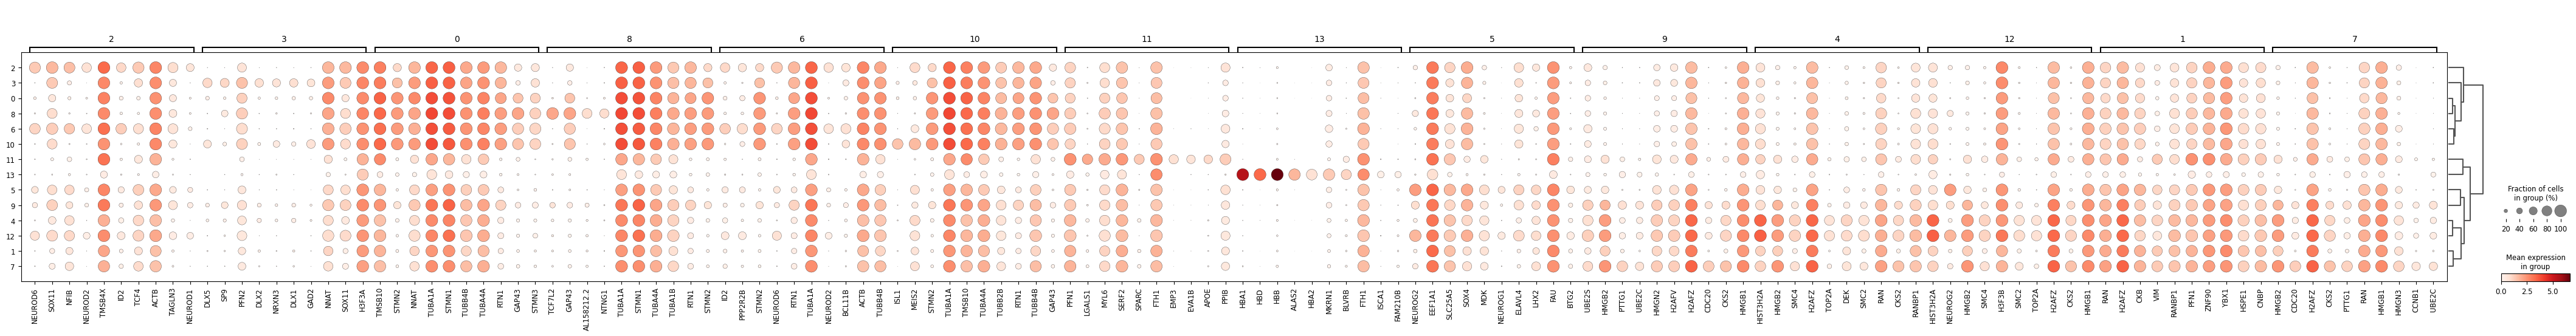

In [6]:
samples = ["/data/rzh/outs/10X12_3_A_1/outs/filtered_feature_bc_matrix.h5",
           "/data/rzh/outs/10X12_4_A_1/outs/filtered_feature_bc_matrix.h5"]
sampleNames = ['dorsal', 'ventral']
adata = concat_adata(samples, sampleNames, inputFunc=input_adata_10Xh5)
adata = pp(adata)
adata = clu(adata)
adata = marker(adata)

In [36]:
adata = sc.read_h5ad("../resources/testAUCell.h5ad")
adata

AnnData object with n_obs × n_vars = 6397 × 11090
    obs: 'batch', 'mt_frac', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden-1'
    var: 'ID', 'name', 'type', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden-1', 'hvg', 'leiden-1', 'leiden-1_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
def partition_arg_topK(matrix, K, axis=1):
    """
    perform topK based on np.argpartition
    :param matrix: to be sorted
    :param K: select and sort the top K items
    :param axis: 0 or 1. dimension to be sorted.
    :return:
    """
    a_part = np.argpartition(matrix, K, axis=axis)
    if axis == 0:
        row_index = np.arange(matrix.shape[1 - axis])
        a_sec_argsort_K = np.argsort(matrix[a_part[0:K, :], row_index], axis=axis)
        return a_part[0:K, :][a_sec_argsort_K, row_index]
    else:
        column_index = np.arange(matrix.shape[1 - axis])[:, None]
        a_sec_argsort_K = np.argsort(matrix[column_index, a_part[:, 0:K]], axis=axis)
        return a_part[:, 0:K][column_index, a_sec_argsort_K]
    
def naive_topK(matrix, K, axis=1):
    mat = np.argsort(-matrix, axis=axis)
    return mat[:, :K]


adata.obsm['AUCell_rankings'] = pd.DataFrame(naive_topK(adata.X.todense(), k), index=adata.obs_names)

In [6]:
def naive_topK(matrix, K, axis=1):
    mat = np.argsort(-matrix, axis=axis)
    return mat[:, :K]
k = int(len(adata.var_names)*0.05)
adata.obsm['AUCell_rankings'] = pd.DataFrame(naive_topK(adata.X.todense(), k), index=adata.obs_names)

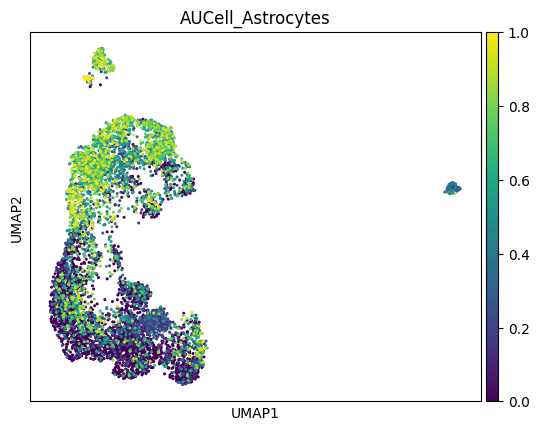

In [7]:
markerList = np.array(["S100B", "SLC1A2", "GFAP", "BYSL", "ALDH1L1", "CD40", "SLC1A3", "FGFR3", "GJB6", "AQP4", "HTRA1", "S100A8", "CLDN10", "ITIH3", "NKAIN4", "ACSL6", "ACSBG1", "TRIL", "AGT", "GPR37L1", "SLC4A4", "NTSR2", "SLC6A11", "HSPA2", "SLC16A2", "SYNE1", "DIO2", "SLC7A10", "ENTPD2", "HSPB6", "PLXNB1", "LCAT", "PLA2G7", "CMTM5", "S1PR1", "SLC39A12", "LUZP2", "GSTA4", "SLC25A28", "SLC25A46", "WNT3", "FZD2", "TEAD1", "RLBP1", "ALDOC", "GJA1", "APOE", "LCN2", "SOX9", "VIM", "CCR7", "AANAT", "FABP7", "SOCS3", "SYNM", "HMG20A", "NFATC3", "SRR", "SLC1A6", "ETS1", "SLIT1", "SNPH", "IL23A"])
markerList = list(set(markerList).intersection(set(adata.var_names)))
from sklearn.metrics import roc_auc_score
y_score = list(range(len(adata.obsm['AUCell_rankings'].columns)))
y_score.reverse()
aucell = np.zeros_like(adata.obs_names)
for i in range(len(adata.obsm['AUCell_rankings'])):
  y_test = adata.var_names[adata.obsm['AUCell_rankings'].iloc[i,:]].isin(markerList)
  if sum(y_test) == 0:
    aucell[i] = 0
  else:
    aucell[i] = roc_auc_score(y_test, y_score)
adata.obs["AUCell_Astrocytes"] = aucell
sc.pl.umap(adata, color="AUCell_Astrocytes")

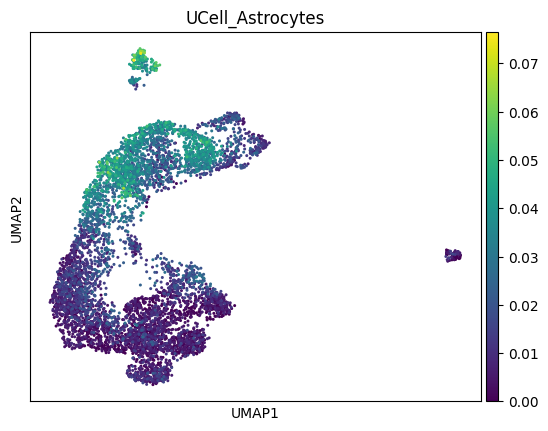

In [8]:
def AUCell_calcUC(adata:ad.AnnData, markerList:list, cellType:str, rankings="AUCell_rankings"):
  varList = list(adata.var_names)
  markerIdx = [varList.index(s) for s in markerList]
  rankMat = adata.obsm[rankings]
  maxRank = len(adata.obsm[rankings].columns)
  n = len(markerIdx)
  smin = n*(n+1)/2
  smax = n*maxRank
  umax = smax - smin
  ucell = np.zeros_like(adata.obs_names)
  for i in range(len(rankMat)):
    mat = rankMat.iloc[i, :]
    intagIdx = mat[mat.isin(markerIdx)]
    if len(intagIdx) == 0:
       ucell[i]=0
    else:
      u = np.sum([list(mat).index(s) for s in intagIdx]) + (n-len(intagIdx))*maxRank - smin
      ucell[i] = 1 - u / umax

  # do knn-smooth
  ucellSmm = np.zeros_like(adata.obs_names)
  knnMat = np.argsort(-adata.obsp["connectivities"].todense(), axis=1)[:,:5]
  for i in range(len(ucell)):
    knnCells = list(knnMat[i])
    ucellSmm[i] = np.mean(ucell[knnCells])
  adata.obs[f"UCell_{cellType}"] = ucellSmm
  return adata

markerList = np.array(["S100B", "SLC1A2", "GFAP", "BYSL", "ALDH1L1", "CD40", "SLC1A3", "FGFR3", "GJB6", "AQP4", "HTRA1", "S100A8", "CLDN10", "ITIH3", "NKAIN4", "ACSL6", "ACSBG1", "TRIL", "AGT", "GPR37L1", "SLC4A4", "NTSR2", "SLC6A11", "HSPA2", "SLC16A2", "SYNE1", "DIO2", "SLC7A10", "ENTPD2", "HSPB6", "PLXNB1", "LCAT", "PLA2G7", "CMTM5", "S1PR1", "SLC39A12", "LUZP2", "GSTA4", "SLC25A28", "SLC25A46", "WNT3", "FZD2", "TEAD1", "RLBP1", "ALDOC", "GJA1", "APOE", "LCN2", "SOX9", "VIM", "CCR7", "AANAT", "FABP7", "SOCS3", "SYNM", "HMG20A", "NFATC3", "SRR", "SLC1A6", "ETS1", "SLIT1", "SNPH", "IL23A"])
markerList = list(set(markerList).intersection(set(adata.var_names)))
AUCell_calcUC(adata, markerList, "Astrocytes")
sc.pl.umap(adata, color="UCell_Astrocytes")

In [22]:
np.argsort(-adata.obsp["connectivities"].todense(), axis=1)[:,:5]

matrix([[4932,  328, 1357, 2005, 4572],
        [2059, 6040, 1119, 2552, 1663],
        [ 965, 3570, 1074, 3229, 4992],
        ...,
        [5703, 3736, 4619, 2673, 2923],
        [2805, 5821, 3928, 2872, 2741],
        [5814, 2563,  699, 5204,  587]])

In [83]:
def AUCell_exploreThreshold(adata:ad.AnnData, cellType:str, assign=True, index="AUCell"):
  aucell = adata.obs[f'{index}_{cellType}']
  bins = np.array(range(10))/10 * np.max(aucell)
  hist = np.histogram(aucell, bins=bins)[0]
  total = len(aucell)
  mean = np.mean(aucell)

  w0, u0, w1, u1, u = 0, 0, 0, 0, 0
  max_variance = 0.0
  threshold = 0
  for i,t in enumerate(bins):
    # 阈值为t时的类间方差计算
    w0 = np.sum(hist[:i]) / total
    w1 = 1 - w0
    if w0 == 0 or w1 == 0:
        continue
    
    u0 = np.sum(hist[:i] * bins[1:i+1]) / w0
    u1 = np.sum(hist[i:] * bins[i+1:]) / w1
    u = u0 * w0 + u1 * w1
    # 类内方差
    var_b = w0 * (u0 - mean) ** 2 + w1 * (u1 - mean) ** 2
    if var_b > max_variance:
        max_variance = var_b
        threshold = t
  
  # add to adata.uns
  if 'AUCThreshold' not in adata.uns:
    adata.uns['AUCThreshold'] = {}
  adata.uns['AUCThreshold'][cellType] = threshold
  if assign:
    assign = aucell[aucell >= threshold] 
    assign.iloc[:] = cellType
    adata.obs[f'{index}_{cellType}_Assignment'] = assign
  print(f"threshold of {cellType} is {threshold}")
  return adata

In [90]:
panglaoDB = pd.read_csv("../resources/PanglaoDB_markers_27_Mar_2020.tsv", sep='\t')
panglaoDB

species official gene symbol                     cell type  \
0      Mm Hs                CTRB1                  Acinar cells   
1      Mm Hs                 KLK1                  Acinar cells   
2      Mm Hs                RBPJL                  Acinar cells   
3      Mm Hs                PTF1A                  Acinar cells   
4         Mm                 TRY4                  Acinar cells   
...      ...                  ...                           ...   
8281   Mm Hs                MYH11  Vascular smooth muscle cells   
8282   Mm Hs               PDGFRB  Vascular smooth muscle cells   
8283   Mm Hs               SEMA3D  Vascular smooth muscle cells   
8284   Mm Hs                TBX18  Vascular smooth muscle cells   
8285   Mm Hs                  WT1  Vascular smooth muscle cells   

                      nicknames  ubiquitousness index  \
0                          CTRB                 0.017   
1                          Klk6                 0.013   
2            RBP-L|SUHL|RBPSUHL                 0.001   
3              PTF1-p48|bHLHa29                 0.001   
4                           NaN                 0.007   
...                         ...                   ...   
8281                 SMMHC|SMHC                 0.015   
8282  JTK12|CD140b|PDGFR1|PDGFR                 0.033   
8283             coll-2|Sema-Z2                 0.005   
8284                        NaN                 0.004   
8285       WIT-2|AWT1|NPHS4|GUD                 0.010   

                                    product description            gene type  \
0                                   chymotrypsinogen B1  protein-coding gene   
1                                          kallikrein 1  protein-coding gene   
2     recombination signal binding protein for immun...  protein-coding gene   
3           pancreas associated transcription factor 1a  protein-coding gene   
4                                             trypsin 4  protein coding gene   
...                                                 ...                  ...   
8281                              myosin heavy chain 11  protein-coding gene   
8282       platelet derived growth factor receptor beta  protein-coding gene   
8283                                      semaphorin 3D  protein-coding gene   
8284                                           T-box 18  protein-coding gene   
8285                                      Wilms tumor 1  protein-coding gene   

      canonical marker germ layer          organ  sensitivity_human  \
0                  1.0   Endoderm       Pancreas           1.000000   
1                  1.0   Endoderm       Pancreas           0.833333   
2                  1.0   Endoderm       Pancreas           0.000000   
3                  1.0   Endoderm       Pancreas           0.000000   
4                  1.0   Endoderm       Pancreas                NaN   
...                ...        ...            ...                ...   
8281               NaN   Mesoderm  Smooth muscle           0.000000   
8282               NaN   Mesoderm  Smooth muscle           0.000000   
8283               NaN   Mesoderm  Smooth muscle           0.000000   
8284               NaN   Mesoderm  Smooth muscle           0.000000   
8285               NaN   Mesoderm  Smooth muscle           0.000000   

      sensitivity_mouse  specificity_human  specificity_mouse  
0              0.957143           0.000629           0.015920  
1              0.314286           0.005031           0.012826  
2              0.000000           0.000000           0.000000  
3              0.157143           0.000629           0.000773  
4                   NaN                NaN                NaN  
...                 ...                ...                ...  
8281           1.000000           0.016291           0.014697  
8282           0.750000           0.036341           0.033246  
8283           0.000000           0.001253           0.000000  
8284           0.000000           0.000313           0.000000

In [96]:
organ = pd.unique(panglaoDB['organ'].dropna())
organ.sort()
organ

array(['Adrenal glands', 'Blood', 'Bone', 'Brain', 'Connective tissue',
       'Embryo', 'Epithelium', 'Eye', 'GI tract', 'Heart',
       'Immune system', 'Kidney', 'Liver', 'Lungs', 'Mammary gland',
       'Olfactory system', 'Oral cavity', 'Pancreas',
       'Parathyroid glands', 'Placenta', 'Reproductive',
       'Skeletal muscle', 'Skin', 'Smooth muscle', 'Thymus', 'Thyroid',
       'Urinary bladder', 'Vasculature', 'Zygote'], dtype=object)

In [218]:
celltype = pd.unique(panglaoDB[panglaoDB['organ'].isin(['Blood', 'Brain'])]['cell type'].dropna())
celltype.sort()
celltype

array(['Adrenergic neurons', 'Anterior pituitary gland cells',
       'Astrocytes', 'Bergmann glia', 'Cajal-Retzius cells',
       'Cholinergic neurons', 'Choroid plexus cells',
       'Dopaminergic neurons', 'Ependymal cells', 'Erythroblasts',
       'Erythroid-like and erythroid precursor cells',
       'GABAergic neurons', 'Glutaminergic neurons',
       'Glycinergic neurons', 'Immature neurons', 'Interneurons',
       'Meningeal cells', 'Microglia', 'Motor neurons',
       'Neural stem/precursor cells', 'Neuroblasts',
       'Neuroendocrine cells', 'Neurons', 'Noradrenergic neurons',
       'Oligodendrocyte progenitor cells', 'Oligodendrocytes',
       'Pinealocytes', 'Platelets', 'Purkinje neurons', 'Pyramidal cells',
       'Radial glia cells', 'Reticulocytes', 'Retinal ganglion cells',
       'Satellite glial cells', 'Schwann cells', 'Serotonergic neurons',
       'Tanycytes', 'Trigeminal neurons'], dtype=object)

In [108]:
def AUCell_calcAUC(adata:ad.AnnData, markerList:list, cellType:str, rankings="AUCell_rankings"):
  markerSet = list(set(markerList).intersection(set(adata.var_names)))
  if rankings in adata.obsm:
    y_score = list(range(len(adata.obsm['AUCell_rankings'].columns)))
    y_score.reverse()
    aucell = np.zeros_like(adata.obs_names)
    for i in range(len(adata.obsm['AUCell_rankings'])):
      y_test = adata.var_names[adata.obsm['AUCell_rankings'].iloc[i,:]].isin(markerSet)
      if sum(y_test) == 0:
        aucell[i] = 0
      else:
        aucell[i] = roc_auc_score(y_test, y_score)
    adata.obs[f"AUCell_{cellType}"] = aucell
  else:
    print(f"{rankings} not found in adata.obsm, run AUCell_buildRankings first.")
  return adata

... storing 'UCell_Pyramidal cells_Assignment' as categorical


threshold of Pyramidal cells is 0.03257039811346927


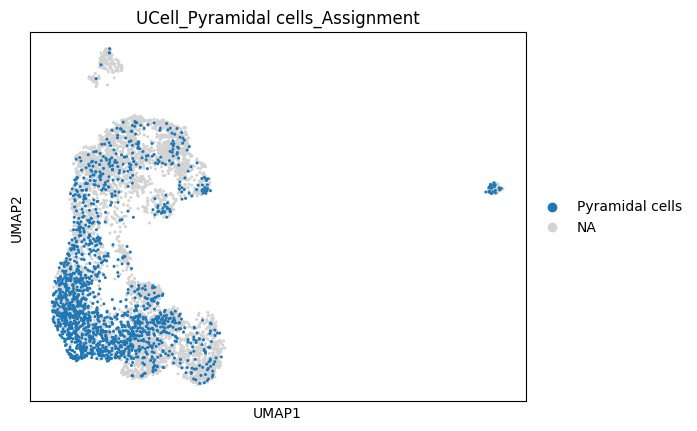

In [138]:
markerList = np.array(panglaoDB[panglaoDB['cell type'] =='Pyramidal cells']['official gene symbol'])
markerList = list(set(markerList).intersection(set(adata.var_names)))
adata = AUCell_calcUC(adata, markerList, "Pyramidal cells")
adata = AUCell_exploreThreshold(adata, "Pyramidal cells", index="UCell")
sc.pl.umap(adata, color="UCell_Pyramidal cells_Assignment")

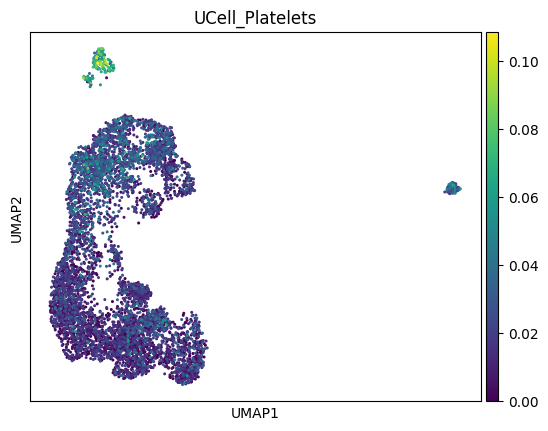

In [135]:
sc.pl.umap(adata, color="UCell_Platelets")

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

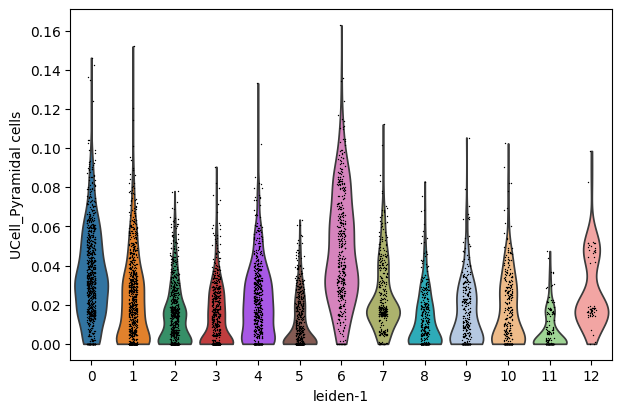

In [171]:
sc.pl.violin(adata, keys="UCell_Pyramidal cells", groupby="leiden-1")

In [196]:
from scipy.stats import wilcoxon, mannwhitneyu, ks_2samp, kruskal

sample1 = adata.obs.loc[adata.obs['leiden-1'].isin(['5']), "UCell_Pyramidal cells"]
sample2 = adata.obs.loc[~adata.obs['leiden-1'].isin(['5']), "UCell_Pyramidal cells"]

samples = adata.obs[['leiden-1', "UCell_Pyramidal cells"]].groupby('leiden-1')

w = kruskal(sample1, sample2)
w

KruskalResult(statistic=164.32322712666542, pvalue=1.2857345452593937e-37)

In [227]:
def AUCell_UCAssign(adata:ad.AnnData, db:pd.DataFrame, celltype:str, alpha=10e-40, gene_col='official gene symbol'):
  annotation = {}
  for ct in celltype:
    candidates = []
    alpha=10e-40
    markerList = np.array(db[db['cell type'] ==ct][gene_col])
    markerList = list(set(markerList).intersection(set(adata.var_names)))
    adata = AUCell_calcUC(adata, markerList, ct)
    ucell = adata.obs[["leiden-1", f"UCell_{ct}"]]
    rank = ucell.groupby("leiden-1").mean()
    rank = rank.sort_values(by=f"UCell_{ct}", ascending=False)
    rank = rank.reset_index()

    for i in range(len(rank)):
      anno = rank.iloc[i,0]
      sample1 = ucell.loc[ucell['leiden-1'].isin([anno]), f"UCell_{ct}"]
      sample2 = ucell.loc[~ucell['leiden-1'].isin([anno]), f"UCell_{ct}"]
      w = kruskal(sample1, sample2)
      if w.pvalue < alpha:
        candidates.append(anno)
        ucell = ucell[~ucell['leiden-1'].isin([anno])]
      else:
        break
    if len(candidates) > 0:
      annotation[ct] = candidates
  adata.uns['UCell_Assign'] = annotation
  return adata

In [228]:
adata = AUCell_UCAssign(adata,panglaoDB,celltype)
adata

AnnData object with n_obs × n_vars = 6377 × 10965
    obs: 'batch', 'mt_frac', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden-1', 'AUCell_Astrocytes', 'UCell_Astrocytes', 'AUCell_Astrocytes_Assignment', 'UCell_Astrocytes_Assignment', 'UCell_Interneuron', 'UCell_Interneuron_Assignment', 'UCell_Microglia', 'UCell_Microglia_Assignment', 'AUCell_Microglia', 'AUCell_Microglia_Assignment', 'UCell_Neurons', 'UCell_Neurons_Assignment', 'UCell_Oligodendrocytes', 'UCell_Oligodendrocytes_Assignment', 'UCell_Pyramidal cells', 'UCell_Pyramidal cells_Assignment', 'UCell_Platelets', 'UCell_Platelets_Assignment', 'UCell_Ependymal cells', 'UCell_Ependymal cells_Assignment', 'UCell_Schwann cells', 'UCell_Schwann cells_Assignment', 'UCell_Neuroblasts', 'UCell_Neuroblasts_Assignment', 'UCell_Interneurons', 'UCell_Reticulocytes', 'UCell_Adrenergic neurons', 'UCell_Anterior pituitary gland cells', 'UCell_Bergmann glia', 'UCell_Cajal-Retzius cells', 'UCell_Cholinergic neurons', 'UCell_C

In [232]:
panglaoDB[panglaoDB['cell type'] == 'B cells naive']

species official gene symbol      cell type  \
597   Mm Hs                 CD19  B cells naive   
598   Mm Hs                  CD2  B cells naive   
599   Mm Hs                 CD72  B cells naive   
600   Mm Hs                IL2RA  B cells naive   
601   Mm Hs                  MME  B cells naive   
..      ...                  ...            ...   
661   Mm Hs            TNFRSF13C  B cells naive   
662      Hs            LINC00926  B cells naive   
663   Mm Hs                STAG3  B cells naive   
664   Mm Hs                BIRC3  B cells naive   
665   Mm Hs                 CD74  B cells naive   

                                     nicknames  ubiquitousness index  \
597                                        NaN                 0.007   
598                                        NaN                 0.040   
599                                 LYB2|CD72b                 0.003   
600                                IL2R|IDDM10                 0.009   
601                                 CALLA|CD10                 0.017   
..                                         ...                   ...   
661                                BAFFR|CD268                 0.008   
662                                        NaN                 0.003   
663                                        NaN                 0.006   
664  cIAP2|hiap-1|MIHC|RNF49|MALT2|c-IAP2|API2                 0.026   
665                                      DHLAG                 0.169   

                            product description            gene type  \
597                               CD19 molecule  protein-coding gene   
598                                CD2 molecule  protein-coding gene   
599                               CD72 molecule  protein-coding gene   
600        interleukin 2 receptor subunit alpha  protein-coding gene   
601               membrane metalloendopeptidase  protein-coding gene   
..                                          ...                  ...   
661         TNF receptor superfamily member 13C  protein-coding gene   
662  long intergenic non-protein coding RNA 926       non-coding RNA   
663                           stromal antigen 3  protein-coding gene   
664         baculoviral IAP repeat containing 3  protein-coding gene   
665                               CD74 molecule  protein-coding gene   

     canonical marker germ layer          organ  sensitivity_human  \
597               1.0   Mesoderm  Immune system           0.000000   
598               NaN   Mesoderm  Immune system           0.000000   
599               1.0   Mesoderm  Immune system           0.000000   
600               NaN   Mesoderm  Immune system           0.000000   
601               NaN   Mesoderm  Immune system           0.000000   
..                ...        ...            ...                ...   
661               1.0   Mesoderm  Immune system           0.933333   
662               1.0   Mesoderm  Immune system           0.933333   
663               1.0   Mesoderm  Immune system           0.066667   
664               1.0   Mesoderm  Immune system           0.533333   
665               1.0   Mesoderm  Immune system           1.000000   

     sensitivity_mouse  specificity_human  specificity_mouse  
597                0.0           0.007869           0.006096  
598                0.0           0.094429           0.029644  
599                0.0           0.001889           0.002823  
600                0.0           0.020145           0.006737  
601                0.0           0.027070           0.015014  
..                 ...                ...                ...  
661                0.0           0.014794           0.000000  
662                0.0           0.011331           0.000000  
663                0.0           0.018256           0.000000  
664                0.0           0.081209           0.014886  
665                0.0           0.360718           0.125184  

[69 rows x 14 columns]

In [242]:
panglaoDB[panglaoDB['official gene symbol'].isin(['B3GALT6', 'CCNL2', 'MS4A1',
                                                  'FNDC10', 'CDK11A', 
                                                  'CDK11B', 'GNB1', 
                                                  'CASP9', 'PGD',
                                                  'MIIP', 'MRPL20-AS1','SLC35E2A', 'CALML6', 'PRKCZ', 'PRXL2B', 'NMNAT1'])]

species official gene symbol            cell type        nicknames  \
423    Mm Hs                MS4A1              B cells  Bp35|MS4A2|CD20   
578    Mm Hs                MS4A1       B cells memory  Bp35|MS4A2|CD20   
638    Mm Hs                MS4A1        B cells naive  Bp35|MS4A2|CD20   
3034   Mm Hs                PRKCZ  Gastric chief cells             PKC2   
6098   Mm Hs                PRKCZ     Oligodendrocytes             PKC2   
6561   Mm Hs                MS4A1         Plasma cells  Bp35|MS4A2|CD20   

      ubiquitousness index             product description  \
423                  0.014  membrane spanning 4-domains A1   
578                  0.014  membrane spanning 4-domains A1   
638                  0.014  membrane spanning 4-domains A1   
3034                 0.022           protein kinase C zeta   
6098                 0.022           protein kinase C zeta   
6561                 0.014  membrane spanning 4-domains A1   

                gene type  canonical marker germ layer          organ  \
423   protein-coding gene               1.0   Mesoderm  Immune system   
578   protein-coding gene               1.0   Mesoderm  Immune system   
638   protein-coding gene               1.0   Mesoderm  Immune system   
3034  protein-coding gene               1.0   Endoderm       GI tract   
6098  protein-coding gene               1.0   Ectoderm          Brain   
6561  protein-coding gene               1.0   Mesoderm  Immune system   

      sensitivity_human  sensitivity_mouse  specificity_human  \
423            0.483871           0.620155           0.011182   
578            0.000000           0.000000           0.020363   
638            1.000000           0.000000           0.015738   
3034           0.000000           0.000000           0.000000   
6098           0.000000           0.203753           0.000000   
6561           0.000000           0.000000           0.020596   

      specificity_mouse  
423            0.001566  
578            0.011806  
638            0.011806  
3034           0.028104  
6098           0.019273  
6561           0.011807

In [244]:
adata.uns['UCell_Assign']

{'Astrocytes': ['11', '2', '8', '5'],
 'Erythroid-like and erythroid precursor cells': ['12'],
 'GABAergic neurons': ['3', '1', '7'],
 'Glutaminergic neurons': ['0', '5'],
 'Glycinergic neurons': ['3', '1'],
 'Immature neurons': ['4', '6', '0'],
 'Meningeal cells': ['9'],
 'Microglia': ['11'],
 'Motor neurons': ['1', '3'],
 'Neural stem/precursor cells': ['3', '4', '10', '5', '2'],
 'Neuroblasts': ['4', '10', '3', '9'],
 'Neurons': ['9', '1', '7', '3'],
 'Oligodendrocyte progenitor cells': ['1', '3', '9', '7', '6', '0'],
 'Platelets': ['11'],
 'Purkinje neurons': ['3'],
 'Pyramidal cells': ['6', '0'],
 'Radial glia cells': ['5', '8', '2', '4'],
 'Retinal ganglion cells': ['1'],
 'Tanycytes': ['4']}

... storing 'annotation' as categorical


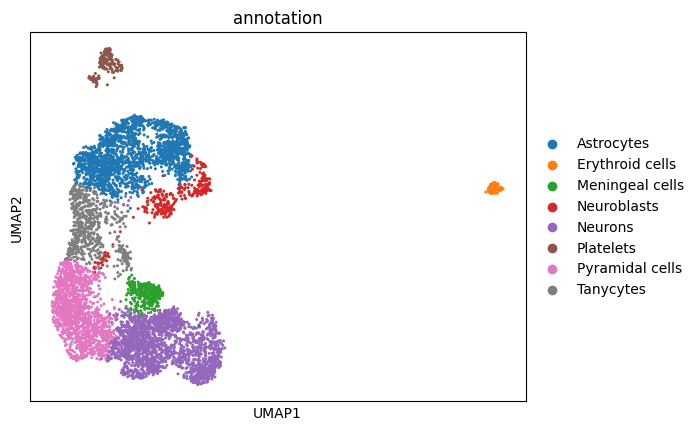

In [246]:
annoDict = {
  'Pyramidal cells': ['6', '0'],
  'Platelets': ['11'],
  'Erythroid cells': ['12'],
  'Astrocytes': ['2', '8', '5'],
  'Meningeal cells': ['9'],
  'Neurons': ['1', '7', '3'],
  'Tanycytes': ['4'],
  'Neuroblasts': ['10'],
}

def anno(adata:ad.AnnData, annoDict:dict):
  adata.obs['annotation'] = 'Unknown'
  for key in annoDict.keys():
    adata.obs.loc[adata.obs['leiden-1'].isin(annoDict[key]), 'annotation'] = key
  return adata

adata = anno(adata, annoDict)
sc.pl.umap(adata, color='annotation')

In [2]:
samples = ["/data/rzh/RawUrls/235/sp/Control02.h5ad",
           "/data/rzh/RawUrls/235/sp/Control05.h5ad",
           "/data/rzh/RawUrls/235/sp/Control06.h5ad",
           "/data/rzh/RawUrls/235/sp/Control09.h5ad"]
sampleNames = ['Control02', 'Control05', 'Control06', 'Control09']
def input_adata_h5ad(sample):
  adata = sc.read_h5ad(sample)
  adata.obs_names_make_unique()
  adata.var_names_make_unique()
  return adata
adata = concat_adata(samples, sampleNames, inputFunc=input_adata_h5ad)
adata.var_names = [s.upper() for s in adata.var_names]
adata

/home/rzh/stpair/backend/server/normalize.py:60: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adatas[0].concatenate(adatas[1:], batch_categories=sampleNames)


AnnData object with n_obs × n_vars = 4598 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'X', 'Y', 'cell_type', 'Apical_vs_Basal_annotation', 'Cx_vs_LGE_annotation', 'LGE_VZ_vs_SVZ_annotation', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [ ]:
adata = pp(adata)
adata = clu(adata)

In [ ]:
adata = sc.read_h5ad()

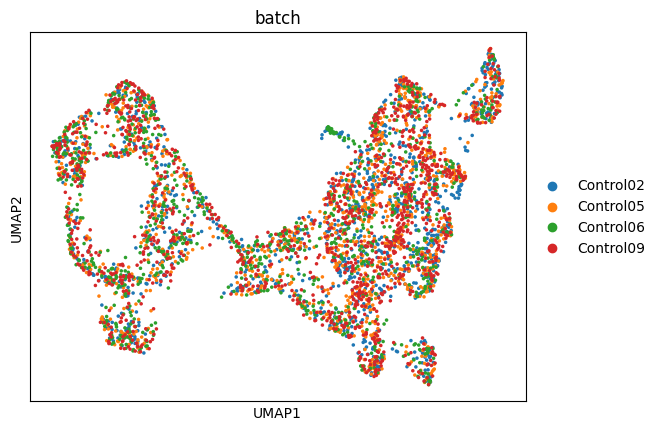

In [32]:
sc.pl.umap(adata, color='batch')

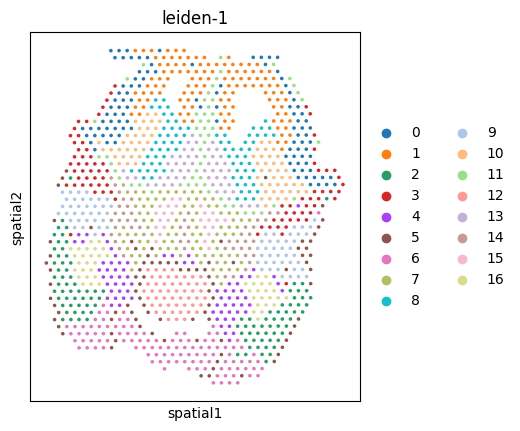

In [37]:
sc.pl.spatial(adata[adata.obs['batch'].isin(['Control09'])], color='leiden-1', spot_size=50)

In [38]:
adata02 = sc.read_h5ad("/data/rzh/RawUrls/235/sp/Control02_processed.h5ad")
adata02

AnnData object with n_obs × n_vars = 1196 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'X', 'Y', 'cell_type', 'Apical_vs_Basal_annotation', 'Cx_vs_LGE_annotation', 'LGE_VZ_vs_SVZ_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

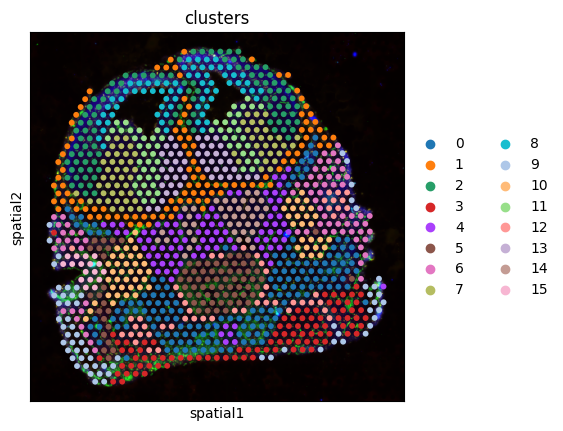

In [39]:
sc.pl.spatial(adata02, color='clusters')

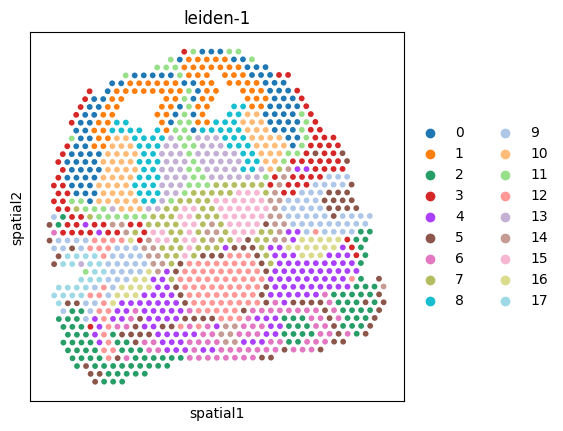

In [44]:
sc.pl.spatial(adata[adata.obs['batch'].isin(['Control02'])], color='leiden-1', spot_size=70)

In [56]:
def AUCell_UCAssign(adata:ad.AnnData, db:pd.DataFrame, celltype:str, alpha=10e-30, gene_col='official gene symbol'):
  annotation = {}
  for ct in celltype:
    candidates = []
    markerList = np.array(db[db['cell type'] ==ct][gene_col])
    markerList = list(set(markerList).intersection(set(adata.var_names)))
    adata = AUCell_calcUC(adata, markerList, ct)
    ucell = adata.obs[["leiden-1", f"UCell_{ct}"]]
    rank = ucell.groupby("leiden-1", observed=False).mean()
    rank = rank.sort_values(by=f"UCell_{ct}", ascending=False)
    rank = rank.reset_index()

    for i in range(len(rank)):
      anno = rank.iloc[i,0]
      sample1 = ucell.loc[ucell['leiden-1'].isin([anno]), f"UCell_{ct}"]
      sample2 = ucell.loc[~ucell['leiden-1'].isin([anno]), f"UCell_{ct}"]
      try:
        w = kruskal(sample1, sample2)
        if w.pvalue < alpha:
          candidates.append(anno)
          ucell = ucell[~ucell['leiden-1'].isin([anno])]
        else:
          break
      except ValueError as e:
        print(e)
        break
    if len(candidates) > 0:
      annotation[ct] = candidates
  adata.uns['UCell_Assign'] = annotation
  adata.obsm['AUCell_rankings'].columns = np.array(adata.obsm['AUCell_rankings'].columns, dtype=str)
  return adata
adata = AUCell_UCAssign(adata, db=panglaoDB, celltype=celltype, alpha=10e-40)

In [57]:
adata.uns['UCell_Assign']

{'Adrenergic neurons': ['13', '10'],
 'Astrocytes': ['1', '8', '14'],
 'Bergmann glia': ['8', '1'],
 'Cajal-Retzius cells': ['0', '13'],
 'Cholinergic neurons': ['10'],
 'Dopaminergic neurons': ['0'],
 'Ependymal cells': ['5', '13'],
 'Erythroid-like and erythroid precursor cells': ['11', '7', '3'],
 'GABAergic neurons': ['10', '13', '8'],
 'Glutaminergic neurons': ['10'],
 'Glycinergic neurons': ['10', '13'],
 'Immature neurons': ['0', '1', '8'],
 'Interneurons': ['13', '10', '0'],
 'Meningeal cells': ['3', '11', '2', '7', '9', '5', '6'],
 'Neural stem/precursor cells': ['1', '8', '10'],
 'Neuroblasts': ['0', '10', '13', '11', '1', '8'],
 'Neuroendocrine cells': ['6'],
 'Neurons': ['13', '10', '0', '11', '3'],
 'Noradrenergic neurons': ['10', '13'],
 'Pinealocytes': ['15'],
 'Platelets': ['2', '6'],
 'Purkinje neurons': ['10', '13'],
 'Pyramidal cells': ['0', '13', '10', '11'],
 'Retinal ganglion cells': ['13'],
 'Satellite glial cells': ['8'],
 'Serotonergic neurons': ['10', '13'],
 

In [64]:
adata.obs

in_tissue  array_row  array_col   X   Y  \
AAACATTTCCCGGATT-1-Control02          1         61         97  61  97   
AAACCGTTCGTCCAGG-1-Control02          1         52         42  52  42   
AAACGAGACGGTTGAT-1-Control02          1         35         79  35  79   
AAACTGCTGGCTCCAA-1-Control02          1         45         67  45  67   
AAAGGCTACGGACCAT-1-Control02          1         62         54  62  54   
...                                 ...        ...        ...  ..  ..   
TTGTGTATGCCACCAA-1-Control09          1         56         60  56  60   
TTGTGTTTCCCGAAAG-1-Control09          1         51         59  51  59   
TTGTTCAGTGTGCTAC-1-Control09          1         24         64  24  64   
TTGTTGTGTGTCAAGA-1-Control09          1         31         77  31  77   
TTGTTTCACATCCAGG-1-Control09          1         58         42  58  42   

                                    cell_type Apical_vs_Basal_annotation  \
AAACATTTCCCGGATT-1-Control02        Cluster 1                  Undefined   
AAACCGTTCGTCCAGG-1-Control02        Cluster 2                  Undefined   
AAACGAGACGGTTGAT-1-Control02  Cortical SVZ/PP                  Undefined   
AAACTGCTGGCTCCAA-1-Control02       Cluster 15                  Undefined   
AAAGGCTACGGACCAT-1-Control02        Cluster 8                  Undefined   
...                                       ...                        ...   
TTGTGTATGCCACCAA-1-Control09       Cluster 11                  Undefined   
TTGTGTTTCCCGAAAG-1-Control09       Cluster 11                  Undefined   
TTGTTCAGTGTGCTAC-1-Control09      Cortical VZ                     Apical   
TTGTTGTGTGTCAAGA-1-Control09      Cortical VZ                  Undefined   
TTGTTTCACATCCAGG-1-Control09        Cluster 6                  Undefined   

                             Cx_vs_LGE_annotation LGE_VZ_vs_SVZ_annotation  \
AAACATTTCCCGGATT-1-Control02            Undefined                Undefined   
AAACCGTTCGTCCAGG-1-Control02            Undefined                Undefined   
AAACGAGACGGTTGAT-1-Control02                  LGE                      SVZ   
AAACTGCTGGCTCCAA-1-Control02            Undefined                Undefined   
AAAGGCTACGGACCAT-1-Control02            Undefined                Undefined   
...                                           ...                      ...   
TTGTGTATGCCACCAA-1-Control09            Undefined                Undefined   
TTGTGTTTCCCGAAAG-1-Control09            Undefined                Undefined   
TTGTTCAGTGTGCTAC-1-Control09                   Cx                Undefined   
TTGTTGTGTGTCAAGA-1-Control09            Undefined                Undefined   
TTGTTTCACATCCAGG-1-Control09            Undefined                Undefined   

                                  batch  ...  UCell_Purkinje neurons  \
AAACATTTCCCGGATT-1-Control02  Control02  ...                0.000000   
AAACCGTTCGTCCAGG-1-Control02  Control02  ...                0.000000   
AAACGAGACGGTTGAT-1-Control02  Control02  ...                0.008744   
AAACTGCTGGCTCCAA-1-Control02  Control02  ...                0.000000   
AAAGGCTACGGACCAT-1-Control02  Control02  ...                0.000000   
...                                 ...  ...                     ...   
TTGTGTATGCCACCAA-1-Control09  Control09  ...                0.000000   
TTGTGTTTCCCGAAAG-1-Control09  Control09  ...                0.000000   
TTGTTCAGTGTGCTAC-1-Control09  Control09  ...                0.009538   
TTGTTGTGTGTCAAGA-1-Control09  Control09  ...                0.000000   
TTGTTTCACATCCAGG-1-Control09  Control09  ...                0.000000   

                              UCell_Pyramidal cells  UCell_Radial glia cells  \
AAACATTTCCCGGATT-1-Control02               0.024182                 0.000000   
AAACCGTTCGTCCAGG-1-Control02               0.027713                 0.000000   
AAACGAGACGGTTGAT-1-Control02               0.093129                 0.000000   
AAACTGCTGGCTCCAA-1-Control02               0.046009                 0.000000   
AAAGGCTACGGACCAT-1-Control02          

In [71]:
adata

AnnData object with n_obs × n_vars = 4597 × 17859
    obs: 'in_tissue', 'array_row', 'array_col', 'X', 'Y', 'cell_type', 'Apical_vs_Basal_annotation', 'Cx_vs_LGE_annotation', 'LGE_VZ_vs_SVZ_annotation', 'batch', 'mt_frac', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden-1', 'UCell_Adrenergic neurons', 'UCell_Anterior pituitary gland cells', 'UCell_Astrocytes', 'UCell_Bergmann glia', 'UCell_Cajal-Retzius cells', 'UCell_Cholinergic neurons', 'UCell_Choroid plexus cells', 'UCell_Dopaminergic neurons', 'UCell_Ependymal cells', 'UCell_Erythroblasts', 'UCell_Erythroid-like and erythroid precursor cells', 'UCell_GABAergic neurons', 'UCell_Glutaminergic neurons', 'UCell_Glycinergic neurons', 'UCell_Immature neurons', 'UCell_Interneurons', 'UCell_Meningeal cells', 'UCell_Microglia', 'UCell_Motor neurons', 'UCell_Neural stem/precursor cells', 'UCell_Neuroblasts', 'UCell_Neuroendocrine cells', 'UCell_Neurons', 'UCell_Noradrenergic neurons', 'UCell_Oligodendrocyte progenitor c

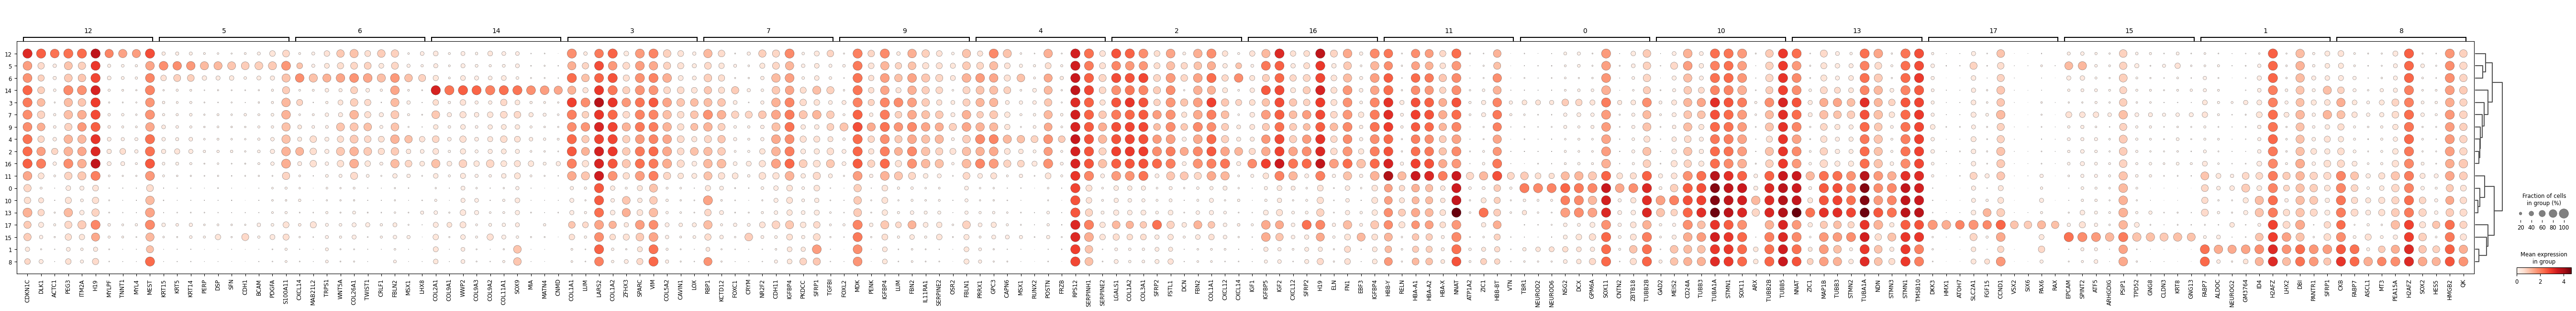

In [75]:
adata = marker(adata, groupby='leiden-1')
adata.obs['annotation'] = adata.obs['leiden-1']
adata.obs.columns = [s.replace('/', ' or ') for s in adata.obs.columns]
adata.obsm['AUCell_rankings'] = np.array(adata.obsm['AUCell_rankings'], dtype=int)
adata0 = adata[:,adata.var['highly_variable']].copy()
adata0.write_h5ad("/data/rzh/RawUrls/235/sp/sp1.h5ad")

In [4]:
adata0 = sc.read_h5ad("/data/rzh/RawUrls/235/sp/sp1.h5ad")
adata0

AnnData object with n_obs × n_vars = 4597 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'X', 'Y', 'cell_type', 'Apical_vs_Basal_annotation', 'Cx_vs_LGE_annotation', 'LGE_VZ_vs_SVZ_annotation', 'batch', 'mt_frac', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'leiden-1', 'UCell_Adrenergic neurons', 'UCell_Anterior pituitary gland cells', 'UCell_Astrocytes', 'UCell_Bergmann glia', 'UCell_Cajal-Retzius cells', 'UCell_Cholinergic neurons', 'UCell_Choroid plexus cells', 'UCell_Dopaminergic neurons', 'UCell_Ependymal cells', 'UCell_Erythroblasts', 'UCell_Erythroid-like and erythroid precursor cells', 'UCell_GABAergic neurons', 'UCell_Glutaminergic neurons', 'UCell_Glycinergic neurons', 'UCell_Immature neurons', 'UCell_Interneurons', 'UCell_Meningeal cells', 'UCell_Microglia', 'UCell_Motor neurons', 'UCell_Neural stem or precursor cells', 'UCell_Neuroblasts', 'UCell_Neuroendocrine cells', 'UCell_Neurons', 'UCell_Noradrenergic neurons', 'UCell_Oligodendrocyte progenitor

In [ ]:
sc.tl.umap(adata0, )